In [14]:
cell_pixel[2]

(array([893, 893, 894, ..., 954, 955, 955]),
 array([1530, 1531, 1528, ..., 1500, 1491, 1492]))

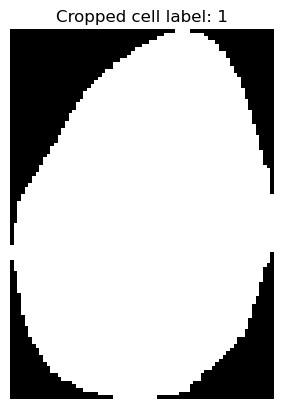

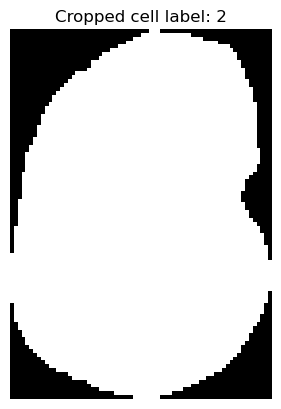

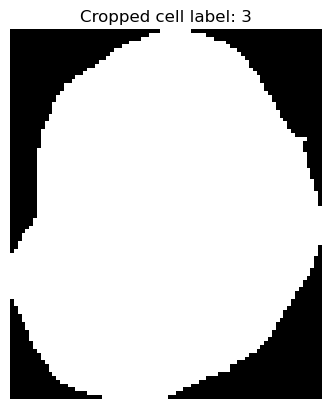

In [1]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

# 🟨 Step 1: Load the labeled mask image (output from Cellpose)
img_path = '/home/zhz187/Downloads/project/nikon6_cropped_imgs/nikon6_15_cp_masksS.tif'  # 🟨 Your input file
sample_mask = tiff.imread(img_path)

# 🟨 Step 2: Get unique labels in the mask (excluding 0, which is background)
uni_label_list = np.unique(sample_mask)

cell_pixel = []
cropped_cells = []  # 🟨 Will hold cropped images per label

# 🟨 Step 3: Loop through each label, crop region using bounding box
for label in uni_label_list:
    if label == 0:
        continue  # Skip background

    # Get pixel coordinates for this label
    coords = np.where(sample_mask == label)
    cell_pixel.append(coords)

    # Compute bounding box
    y_min, y_max = np.min(coords[0]), np.max(coords[0])
    x_min, x_max = np.min(coords[1]), np.max(coords[1])

    # Crop the label region from the mask
    cropped = sample_mask[y_min:y_max + 1, x_min:x_max + 1]
    cropped_cells.append(cropped)

    # 🟨 Optional: visualize the first few crops
    if label <= 100:
        plt.imshow(cropped, cmap='gray')
        plt.title(f'Cropped cell label: {label}')
        plt.axis('off')
        plt.show()
        
    # Save cropped mask as separate TIFF
    out_path = f"/home/zhz187/Downloads/project/cropped_mask_label_{label}.tif"
    tiff.imwrite(out_path, cropped.astype(np.uint16))

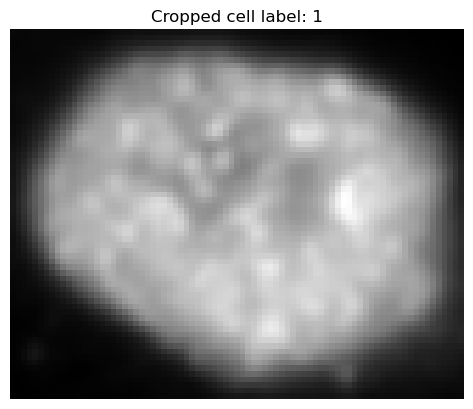

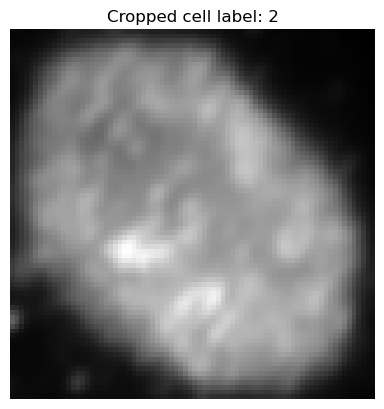

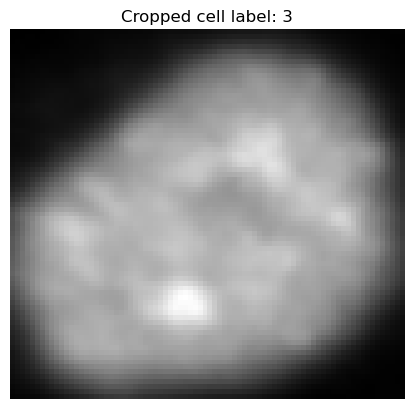

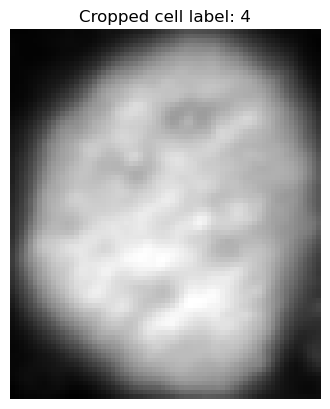

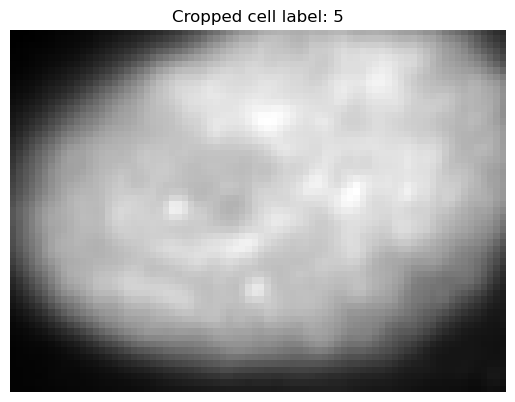

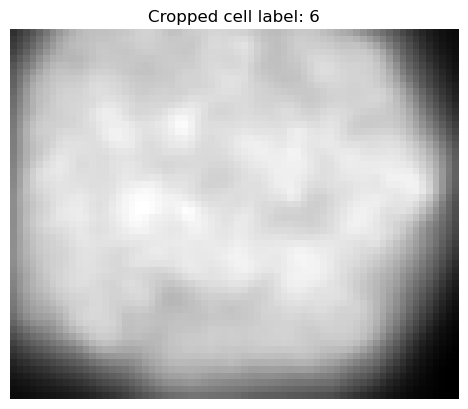

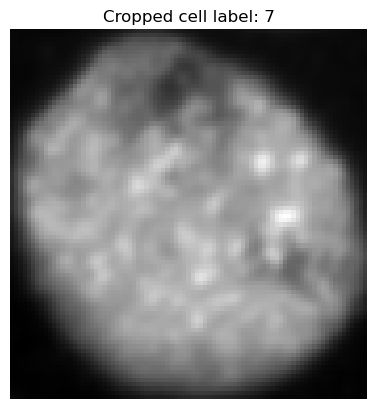

In [308]:
#crop S phase cells

import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the mask (Cellpose output)
mask_path = '/home/zhz187/Downloads/project/nikon6_cropped_imgs/nikon6_3_cp_masksS.tif'
sample_mask = tiff.imread(mask_path)

# Load the original image (same size as mask, e.g., 224x224)
image_path = 'nikon6_cropped_imgs/nikon6_3.tif'  # <-- Replace with actual image path
sample_img = tiff.imread(image_path)

# Validate shape match
assert sample_mask.shape == sample_img.shape, "Image and mask must be the same shape."

# Create output directory for cropped cells
os.makedirs("nikon6_img3_croppedScells", exist_ok=True)

# Get unique cell labels (excluding background)
uni_label_list = np.unique(sample_mask)
cell_pixel = []
cropped_cells = []

for label in uni_label_list:
    if label == 0:
        continue  # Skip background

    # Get pixel coordinates for current cell label
    coords = np.where(sample_mask == label)
    cell_pixel.append(coords)

    # Compute bounding box
    y_min, y_max = np.min(coords[0]), np.max(coords[0])
    x_min, x_max = np.min(coords[1]), np.max(coords[1])

    # Crop corresponding region from original image
    cropped_img = sample_img[y_min:y_max+1, x_min:x_max+1]
    cropped_cells.append(cropped_img)

    # Optional visualization for first few cells
    if label <= 100:
        plt.imshow(cropped_img, cmap='gray')
        plt.title(f'Cropped cell label: {label}')
        plt.axis('off')
        plt.show()

    # Save cropped image
    out_path = f"./nikon6_img3_croppedScells/cell_img_label_{label}.tif"
    tiff.imwrite(out_path, cropped_img.astype(np.uint16))

Found 210 missing cells to crop.


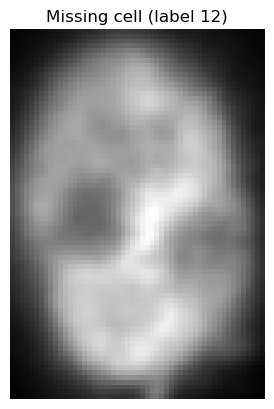

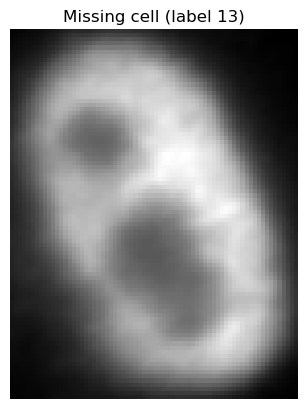

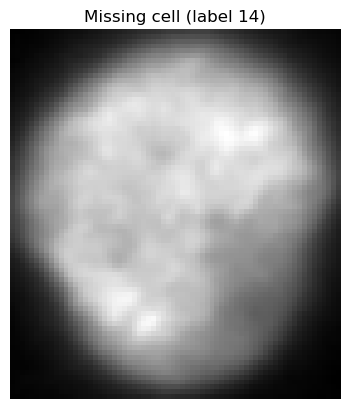

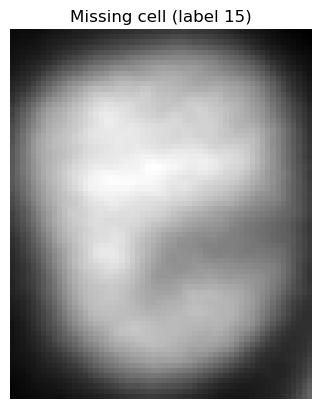

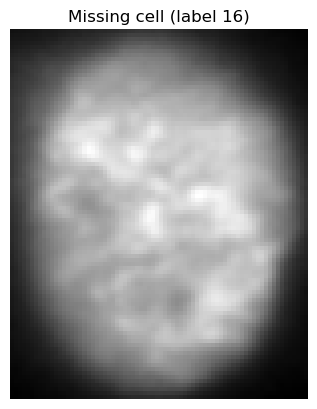

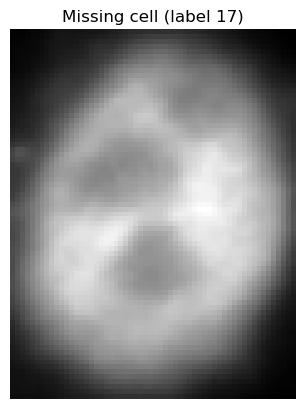

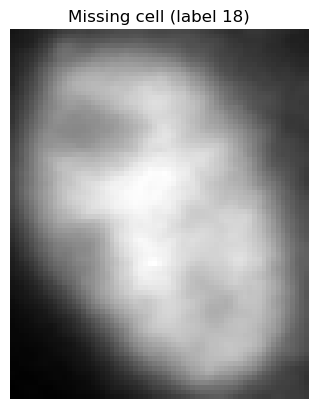

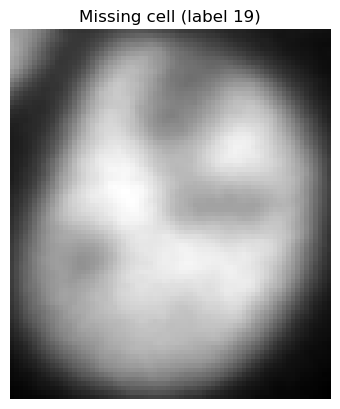

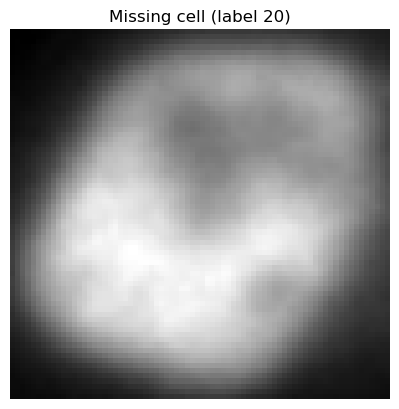

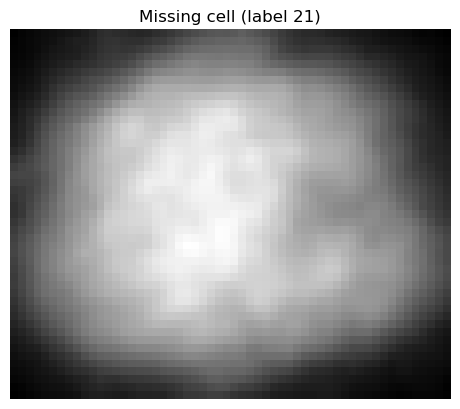

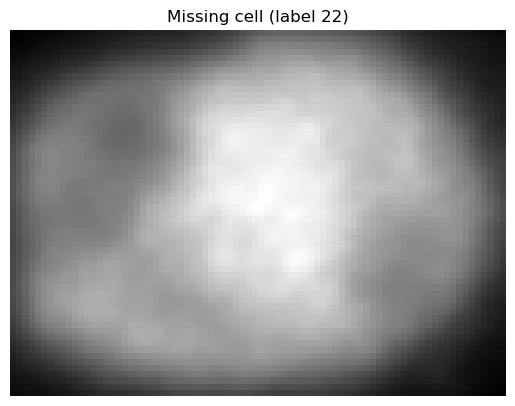

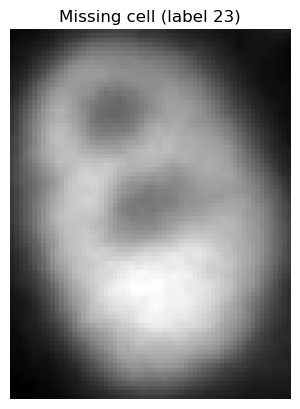

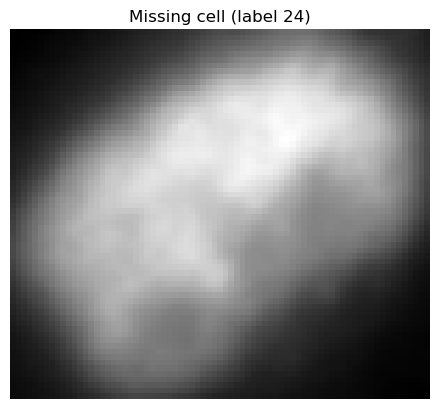

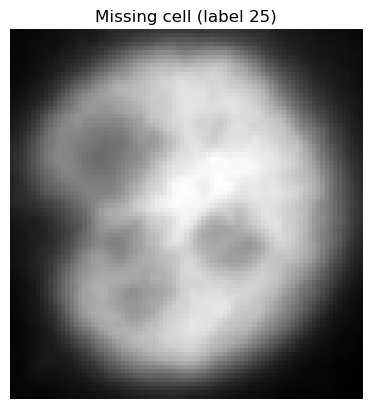

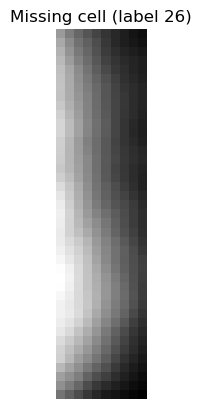

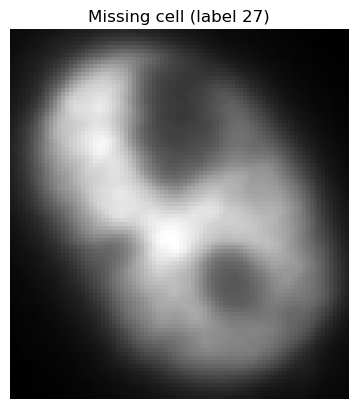

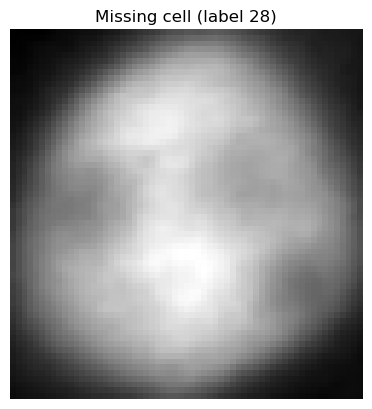

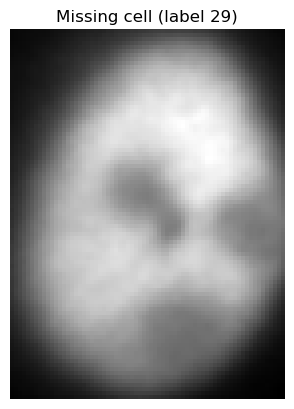

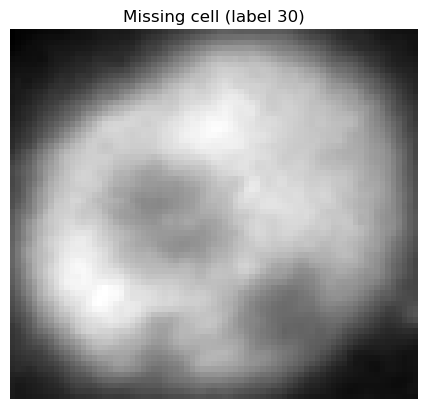

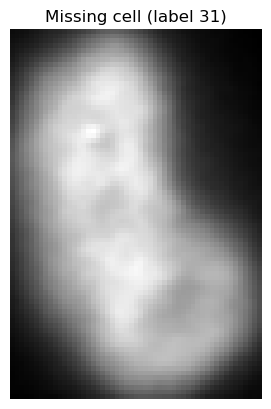

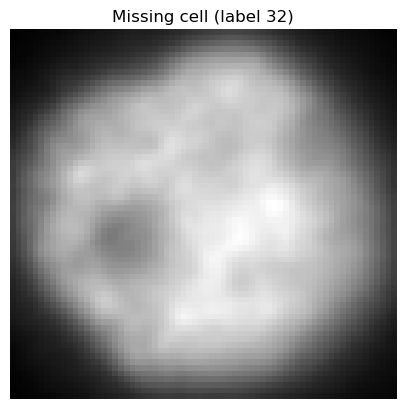

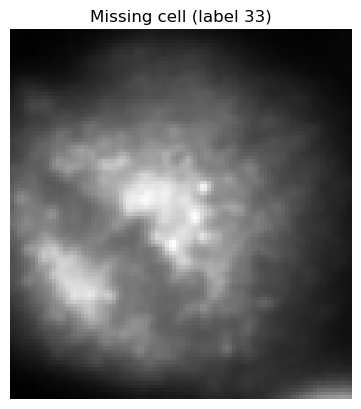

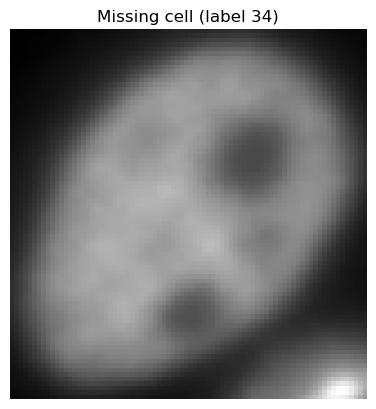

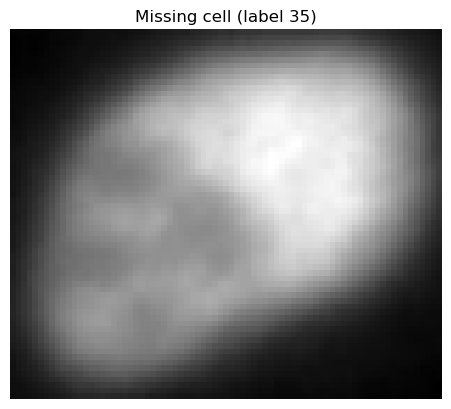

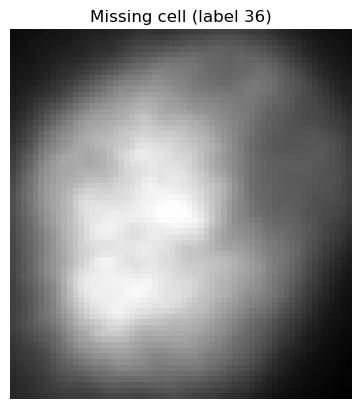

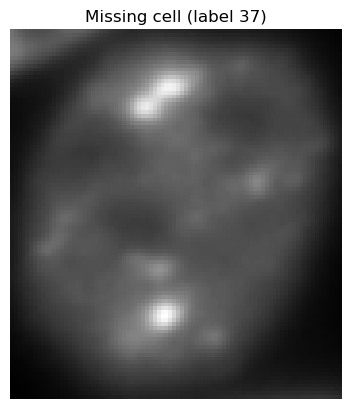

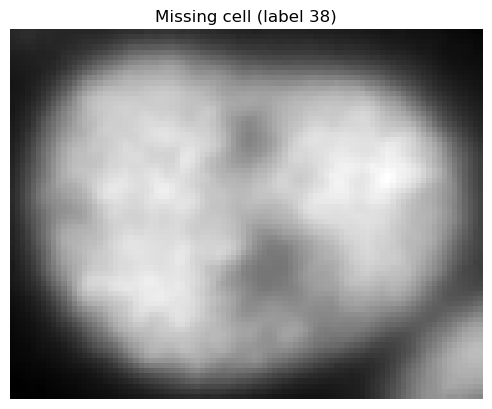

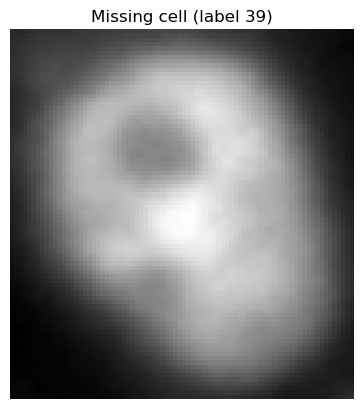

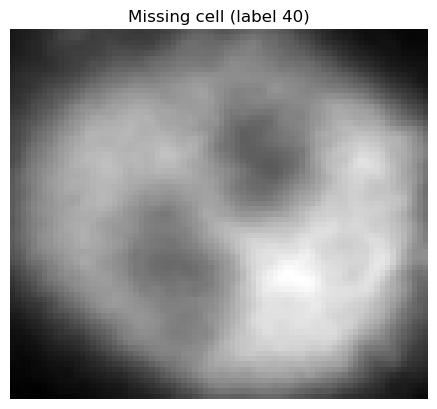

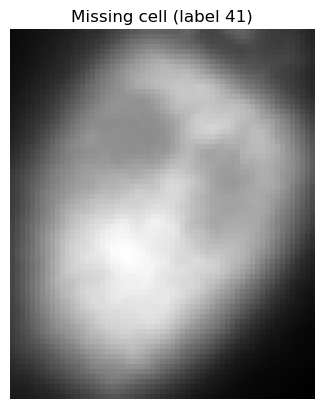

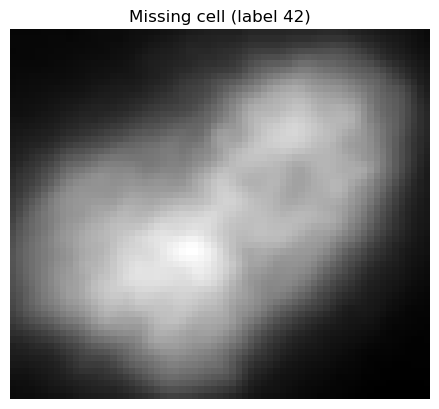

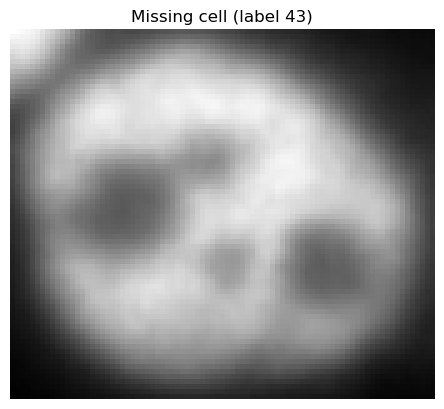

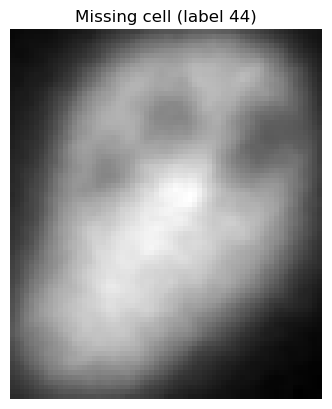

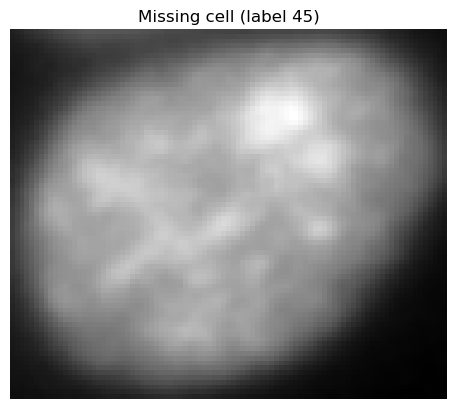

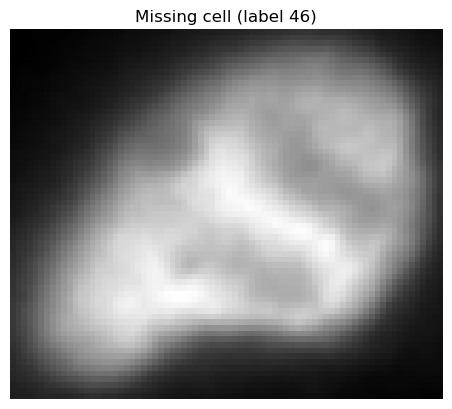

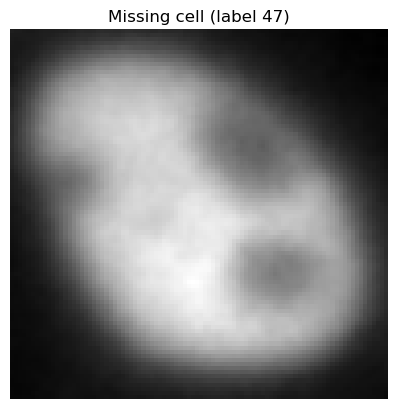

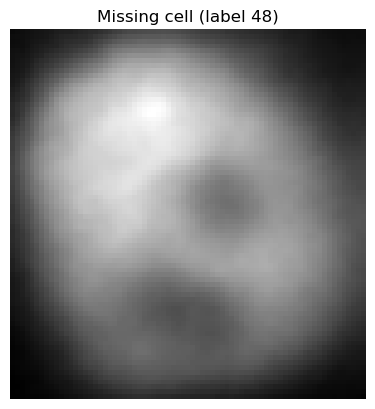

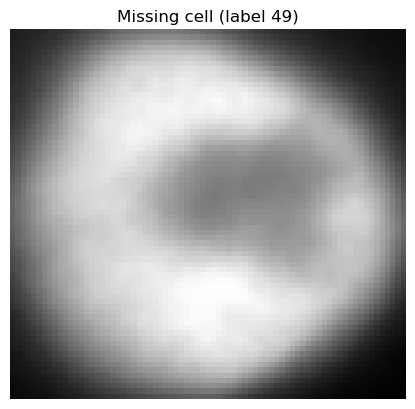

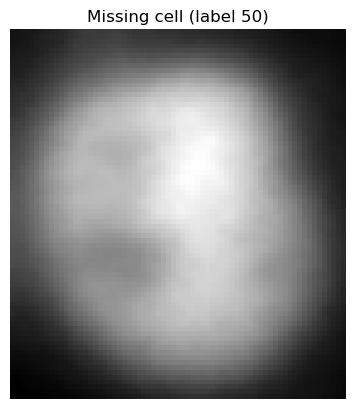

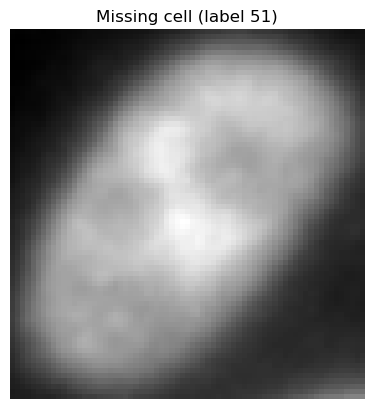

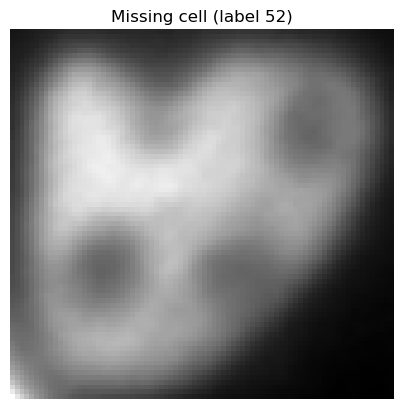

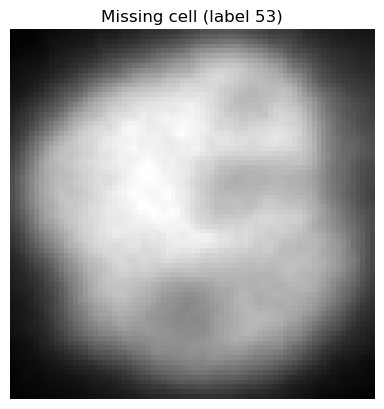

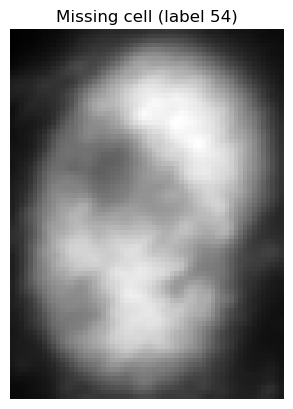

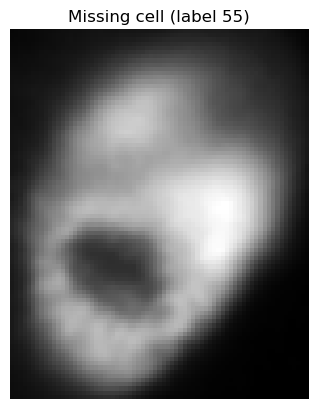

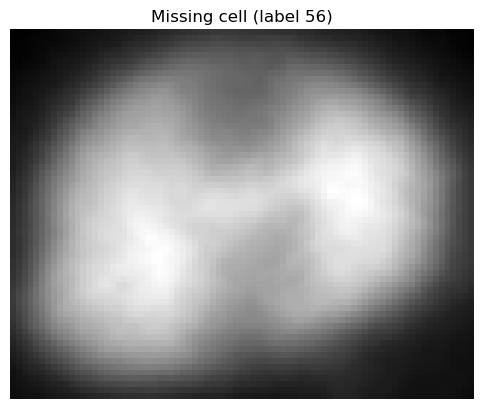

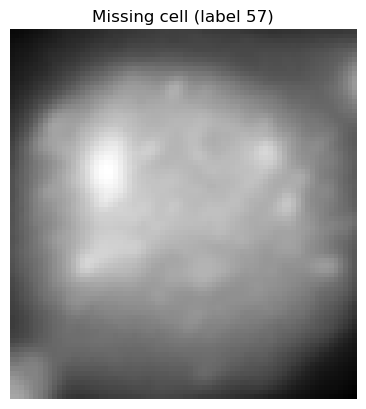

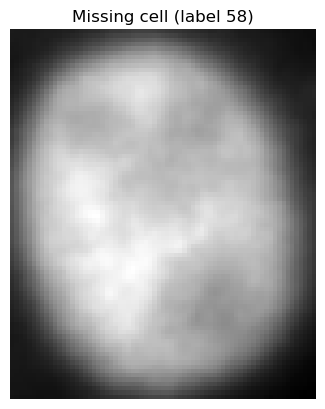

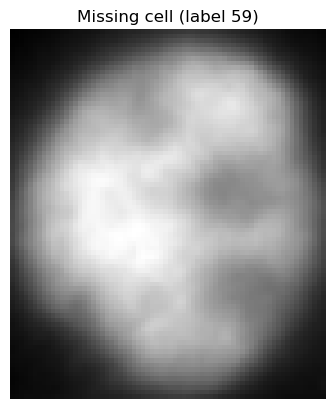

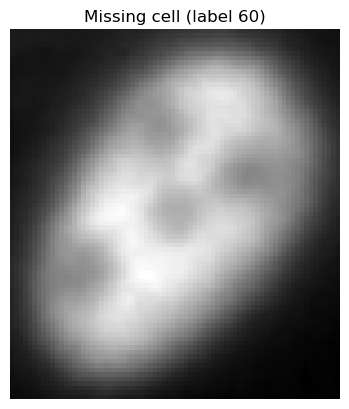

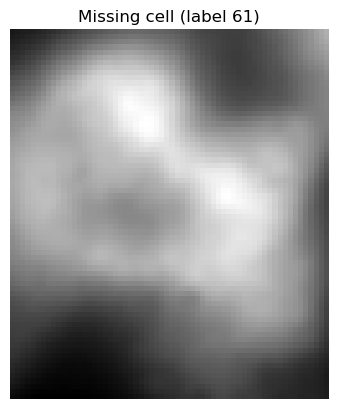

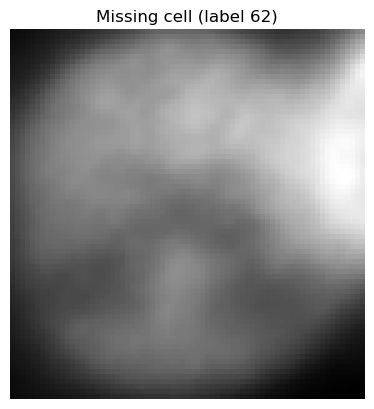

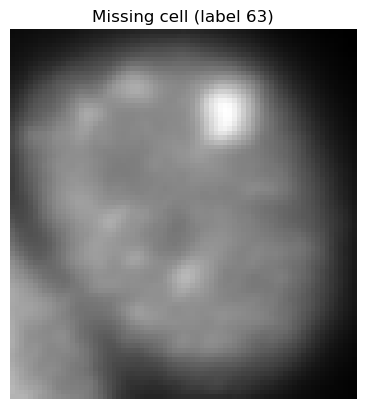

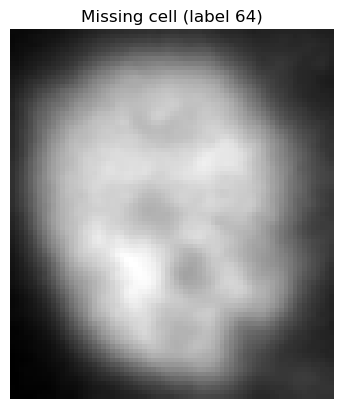

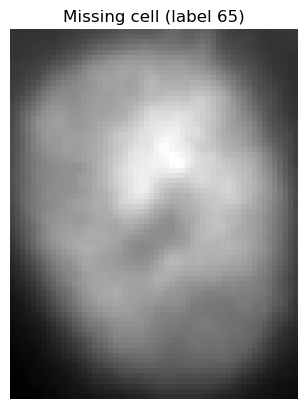

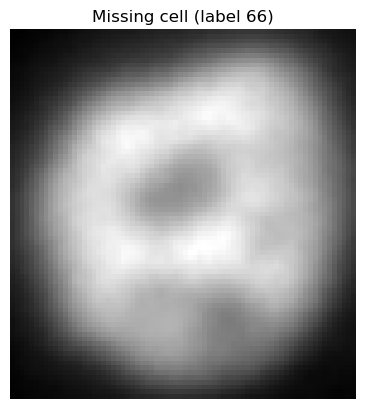

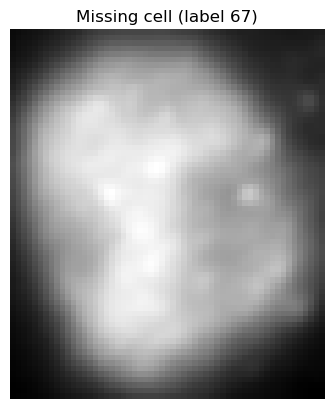

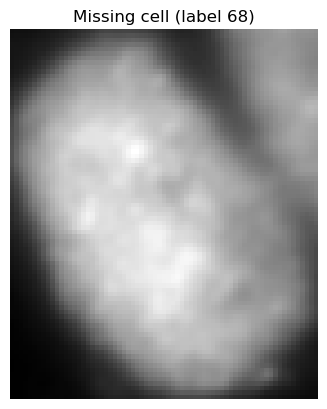

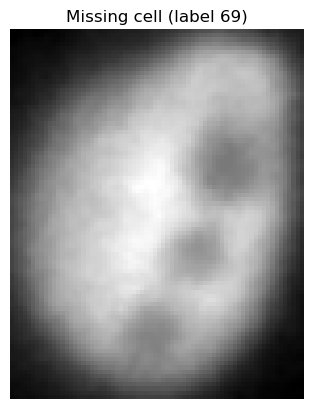

FileNotFoundError: [Errno 2] No such file or directory: '/home/zhz187/Downloads/project/nikon6_image12_cropped_nonScells/missing_cell_img_label_69.tif'

In [307]:
#crop non S phase cells

import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
import os

# === File Paths ===
full_mask_path = '/home/zhz187/Downloads/project/nikon6_cropped_imgs/nikon6_12_cp_all_masks.tif'       # Full set of labels (e.g., ground truth)
partial_mask_path = '/home/zhz187/Downloads/project/nikon6_cropped_imgs/nikon6_12_cp_masksS.tif'  # Partial labels (e.g., Cellpose prediction)
image_path = '/home/zhz187/Downloads/project/nikon6_cropped_imgs/nikon6_12.tif'                  # Original image

# === Load Images ===
full_mask = tiff.imread(full_mask_path)
partial_mask = tiff.imread(partial_mask_path)
original_img = tiff.imread(image_path)

assert full_mask.shape == partial_mask.shape == original_img.shape, "All images must be the same shape."

# === Output Directory ===
os.makedirs("nikon6_image12_cropped_nonScells", exist_ok=True)

# === Get label sets ===
full_labels = set(np.unique(full_mask)) - {0}       # Exclude background
partial_labels = set(np.unique(partial_mask)) - {0}

# === Find missing labels ===
missing_labels = full_labels - partial_labels
print(f"Found {len(missing_labels)} missing cells to crop.")

# === Crop each missing cell ===
for label in missing_labels:
    coords = np.where(full_mask == label)

    if coords[0].size == 0:
        continue  # Safety check

    y_min, y_max = np.min(coords[0]), np.max(coords[0])
    x_min, x_max = np.min(coords[1]), np.max(coords[1])

    cropped_img = original_img[y_min:y_max+1, x_min:x_max+1]

    # Optional: visualize first few
    if label <= 100:
        plt.imshow(cropped_img, cmap='gray')
        plt.title(f'Missing cell (label {label})')
        plt.axis('off')
        plt.show()

    # Save the crop
    out_path = f"./nikon6_image12_cropped_nonScells/missing_cell_img_label_{label}.tif"
    tiff.imwrite(out_path, cropped_img.astype(np.uint16))

In [5]:
import tifffile as tiff
import numpy as np

# Read the TIFF image
image = tiff.imread('/home/zhz187/Downloads/project/up_mcf10a_nikon1_dapi_dapi_img.tif')  # Replace with your file path

# Get image dimensions
height, width = image.shape[:2]

# Determine size of each tile (assumes divisible)
tile_height = height // 4
tile_width = width // 4

# Crop into 4x4 tiles
tiles = []
for i in range(4):
    for j in range(4):
        top = i * tile_height
        left = j * tile_width
        bottom = top + tile_height
        right = left + tile_width

        tile = image[top:bottom, left:right]
        tiles.append(tile)

# Example: print the shape of each tile
for idx, tile in enumerate(tiles):
    print(f"Tile {idx + 1}: shape = {tile.shape}")
    # save the tiles into disk
    out_path = f"/home/zhz187/Downloads/project/cropped_mask_label_{tiles}.tif"
    tiff.imwrite(f'./{idx}.tif', tile)

Tile 1: shape = (1877, 1876)
Tile 2: shape = (1877, 1876)
Tile 3: shape = (1877, 1876)
Tile 4: shape = (1877, 1876)
Tile 5: shape = (1877, 1876)
Tile 6: shape = (1877, 1876)
Tile 7: shape = (1877, 1876)
Tile 8: shape = (1877, 1876)
Tile 9: shape = (1877, 1876)
Tile 10: shape = (1877, 1876)
Tile 11: shape = (1877, 1876)
Tile 12: shape = (1877, 1876)
Tile 13: shape = (1877, 1876)
Tile 14: shape = (1877, 1876)
Tile 15: shape = (1877, 1876)
Tile 16: shape = (1877, 1876)


In [45]:
import os
from pathlib import Path
from PIL import Image
import numpy as np
import tifffile as tiff

# Input and output paths
RAW_VAL_DIR = "/home/zhz187/Downloads/project/raw_pcna_images1"
AUG_VAL_DIR = "/home/zhz187/Downloads/project/augmented_val"

# Rotation and noise options
ROTATION_ANGLES = [-180, -135, -90, -45, 0, 45, 90, 135]
APPLY_NOISE = [False, True]

# Create output directory structure
for cls_name in os.listdir(RAW_VAL_DIR):
    class_dir = os.path.join(RAW_VAL_DIR, cls_name)
    if os.path.isdir(class_dir):
        Path(os.path.join(AUG_VAL_DIR, cls_name)).mkdir(parents=True, exist_ok=True)

def add_gaussian_noise(img_np, mean=0, std=10):
    noise = np.random.normal(mean, std, img_np.shape).astype(np.float32)
    noisy = img_np.astype(np.float32) + noise
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

def augment_and_save():
    for cls_name in os.listdir(RAW_VAL_DIR):
        cls_dir = os.path.join(RAW_VAL_DIR, cls_name)
        if not os.path.isdir(cls_dir):
            continue

        output_dir = os.path.join(AUG_VAL_DIR, cls_name)

        for fname in os.listdir(cls_dir):
            if not fname.endswith(".tif"):
                continue

            base_name = Path(fname).stem
            img_path = os.path.join(cls_dir, fname)
            img_np = tiff.imread(img_path)

            # Convert grayscale to RGB
            if img_np.ndim == 2:
                img_np = np.stack([img_np] * 3, axis=-1)
            elif img_np.ndim == 3 and img_np.shape[0] == 1:
                img_np = np.repeat(img_np[0][..., np.newaxis], 3, axis=-1)

            # Normalize image to uint8 if needed
            if img_np.dtype != np.uint8:
                img_np = (img_np / img_np.max() * 255).astype(np.uint8)

            for angle in ROTATION_ANGLES:
                pil_img = Image.fromarray(img_np).rotate(angle)
                rotated_np = np.array(pil_img)

                for noise_flag in APPLY_NOISE:
                    if noise_flag:
                        final_img = add_gaussian_noise(rotated_np)
                        suffix = f"rot{angle}_noise"
                    else:
                        final_img = rotated_np
                        suffix = f"rot{angle}_clean"

                    out_name = f"{base_name}_{suffix}.tif"
                    out_path = os.path.join(output_dir, out_name)
                    tiff.imwrite(out_path, final_img)

    print("✅ Augmented validation set generated and saved.")

# Run the augmentation
augment_and_save()


✅ Augmented validation set generated and saved.


In [46]:
#splits dataset

import os
import shutil
import random
from pathlib import Path

# Directories
SOURCE_DIR = "/home/zhz187/Downloads/project/augmented_val"
DEST_DIR = "/home/zhz187/Downloads/project/pcna_dataset"

CLASSES = ["s_phase", "non_s_phase"]
train_ratio = 0.8
random.seed(42)

# Create destination directories
for phase in ["train", "val"]:
    for cls in CLASSES:
        Path(os.path.join(DEST_DIR, phase, cls)).mkdir(parents=True, exist_ok=True)

# Load and split files
train_files = {}
val_files = {}

for cls in CLASSES:
    cls_path = Path(SOURCE_DIR) / cls
    all_cls_files = list(cls_path.rglob("*.tif"))
    random.shuffle(all_cls_files)
    split_idx = int(len(all_cls_files) * train_ratio)
    train_files[cls] = all_cls_files[:split_idx]
    val_files[cls] = all_cls_files[split_idx:]
    print(f"{cls}: {len(train_files[cls])} train, {len(val_files[cls])} val files")

# Function to balance files
def balance_file_list(file_list, target_size):
    if len(file_list) >= target_size:
        return random.sample(file_list, target_size)
    multiplier = target_size // len(file_list)
    remainder = target_size % len(file_list)
    balanced = file_list * multiplier + random.sample(file_list, remainder)
    random.shuffle(balanced)
    return balanced

# Balance training and validation sets separately
max_train_size = max(len(train_files[cls]) for cls in CLASSES)
max_val_size = max(len(val_files[cls]) for cls in CLASSES)

balanced_train = {cls: balance_file_list(train_files[cls], max_train_size) for cls in CLASSES}
balanced_val = {cls: balance_file_list(val_files[cls], max_val_size) for cls in CLASSES}

# Copy files
for phase, file_dict in [("train", balanced_train), ("val", balanced_val)]:
    for cls, files in file_dict.items():
        for src_path in files:
            dst_path = Path(DEST_DIR) / phase / cls / src_path.name
            shutil.copy2(src_path, dst_path)

print("✅ Dataset split and balanced with no overlap between train and val sets.")


s_phase: 1843 train, 461 val files
non_s_phase: 3238 train, 810 val files
✅ Dataset split and balanced with no overlap between train and val sets.


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
import numpy as np
from pathlib import Path

# ------------------ Dataset ------------------
class TiffFolderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        classes = sorted([d.name for d in os.scandir(root_dir) if d.is_dir()])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

        for cls_name in classes:
            cls_dir = os.path.join(root_dir, cls_name)
            for file_name in os.listdir(cls_dir):
                if file_name.endswith(".tif"):
                    self.samples.append((os.path.join(cls_dir, file_name), self.class_to_idx[cls_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        # Read TIFF as float32 for normalization
        img_np = tiff.imread(path).astype(np.float32)

        # Normalize raw image array to [0,1]
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)

        # Convert to 8-bit for PIL compatibility
        img_np_8bit = (img_np * 255).astype(np.uint8)

        img = Image.fromarray(img_np_8bit)

        # Convert to RGB if not already
        if img.mode != 'RGB':
            img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, label

# ------------------ Transforms ------------------
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=(-180, 180), expand=False),  # Full ±180 degrees rotation
    transforms.GaussianBlur(kernel_size=3, sigma=(0.5, 2.5)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
])

# ------------------ Paths & Data ------------------
DATASET_PATH = "/home/zhz187/Downloads/project/pcna_dataset"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_data = TiffFolderDataset(os.path.join(DATASET_PATH, "train"), transform=train_transform)
val_data = TiffFolderDataset(os.path.join(DATASET_PATH, "val"), transform=val_transform)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

# ------------------ Plot Saving Directory ------------------
PLOTS_DIR = "/home/zhz187/Downloads/project/plots"
Path(PLOTS_DIR).mkdir(parents=True, exist_ok=True)

# ------------------ Save Augmented Examples Individually ------------------
def save_augmented_examples_individually_as_tiff(dataset, n=5):
    """
    Save 'n' augmented examples individually as TIFF files for inspection.
    """
    for i in range(n):
        img, label = dataset[i]
        img = torch.clamp(img, 0, 1)

        np_img = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
        filename = os.path.join(PLOTS_DIR, f"train_aug_sample_{i+1}_label_{label}.tif")
        tiff.imwrite(filename, np_img)
        print(f"✅ Saved: {filename}")

print("Saving augmented training examples for inspection...")
save_augmented_examples_individually_as_tiff(train_data, n=5)


# ------------------ 3-Layer CNN ------------------
class ThreeLayerCNN(nn.Module):
    def __init__(self):
        super(ThreeLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 32, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 64, 32, 32]
        x = self.pool(F.relu(self.conv3(x)))  # [B, 128, 16, 16]
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ------------------ Model Setup ------------------
model = ThreeLayerCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

# ------------------ Training ------------------
num_epochs = 100
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation step (accuracy)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

# ------------------ Save Model ------------------
torch.save(model.state_dict(), "pcna_3layer_cnn.pth")
print("✅ Model saved as pcna_3layer_cnn.pth")

# ------------------ Plot Loss Curve ------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "training_loss_curve.png"))
plt.show()

# ------------------ Plot Validation Accuracy Curve ------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy vs Epoch')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "validation_accuracy_curve.png"))
plt.show()


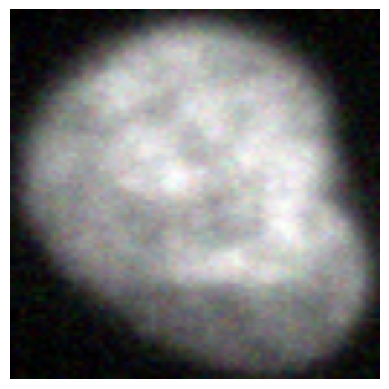

Image: nikon1_img3_cell_img_label_4_rot-180_noise.tif
True Label     : s_phase
Predicted Label: s_phase
Prediction Type: ✅ True Positive (TP)


In [83]:
import os
import torch
import random
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
from torchvision import transforms
from torch import nn

# ------------------ Display Helper ------------------
def imshow_tensor(img_tensor):
    img = img_tensor * 0.5 + 0.5  # De-normalize
    img = img.clamp(0, 1)
    if img.shape[0] == 1:
        img = img.squeeze(0)
        plt.imshow(img.cpu(), cmap='gray')
    else:
        img = img.permute(1, 2, 0)
        plt.imshow(img.cpu())
    plt.axis('off')
    plt.show()

# ------------------ Model (3-layer CNN) ------------------
class ThreeLayerCNN(nn.Module):
    def __init__(self):
        super(ThreeLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # [B, 32, 64, 64]
        x = self.pool(torch.relu(self.conv2(x)))  # [B, 64, 32, 32]
        x = self.pool(torch.relu(self.conv3(x)))  # [B, 128, 16, 16]
        x = x.view(-1, 128 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# ------------------ Paths & Config ------------------
DATASET_PATH = "/home/zhz187/Downloads/project/pcna_dataset"
MODEL_PATH = "pcna_3layer_cnn.pth"
class_names = ['non_s_phase', 's_phase']  # Keep same class order as training
positive_class = "s_phase"

# ------------------ Load Model ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ThreeLayerCNN().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# ------------------ Transforms (must match training) ------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
    transforms.Normalize([0.5] * 3, [0.5] * 3),
])

# ------------------ Pick Random Validation Image ------------------
val_dir = os.path.join(DATASET_PATH, "val")
all_samples = []

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(val_dir, class_name)
    tif_files = [f for f in os.listdir(class_dir) if f.endswith(".tif")]
    for tif_file in tif_files:
        all_samples.append((os.path.join(class_dir, tif_file), class_idx, class_name))

random_path, true_label_idx, true_label_name = random.choice(all_samples)

# ------------------ Load and Preprocess Image ------------------
img_np = tiff.imread(random_path)
if img_np.ndim == 2:
    img = Image.fromarray(img_np).convert('RGB')
else:
    img = Image.fromarray(img_np)
    if img.mode != 'RGB':
        img = img.convert('RGB')

img_tensor = transform(img)

# ------------------ Predict ------------------
input_tensor = img_tensor.unsqueeze(0).to(device)
with torch.no_grad():
    output = model(input_tensor)
    _, pred_idx = torch.max(output, 1)

predicted_label_name = class_names[pred_idx.item()]

# ------------------ Display and Print ------------------
imshow_tensor(img_tensor)
print(f"Image: {os.path.basename(random_path)}")
print(f"True Label     : {true_label_name}")
print(f"Predicted Label: {predicted_label_name}")

# ------------------ Evaluate Result ------------------
if predicted_label_name == positive_class:
    if true_label_name == positive_class:
        condition = "✅ True Positive (TP)"
    else:
        condition = "❌ False Positive (FP)"
else:
    if true_label_name == positive_class:
        condition = "❌ False Negative (FN)"
    else:
        condition = "✅ True Negative (TN)"

print(f"Prediction Type: {condition}")


In [3]:
from sklearn.metrics import confusion_matrix

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix: [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()

    # Calculate metrics as percentages
    accuracy = 100 * (tp + tn) / (tp + tn + fp + fn)
    precision = 100 * tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = 100 * tp / (tp + fn) if (tp + fn) > 0 else 0  # TPR
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    fpr = 100 * fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = 100 * fn / (fn + tp) if (fn + tp) > 0 else 0
    tnr = 100 * tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f"Validation Metrics:")
    print(f"  Accuracy:           {accuracy:.2f}%")
    print(f"  Precision (PPV):    {precision:.2f}%")
    print(f"  Recall (TPR):       {recall:.2f}%")
    print(f"  True Negative Rate: {tnr:.2f}%")
    print(f"  False Positive Rate:{fpr:.2f}%")
    print(f"  False Negative Rate:{fnr:.2f}%")
    print(f"  F1 Score:           {f1_score:.2f}%")

# Call it right after training loop:
evaluate_model(model, val_loader, device)


NameError: name 'model' is not defined